In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import seaborn

import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size, input_size, hidden_size, output_size = 100, 3*32*32, 512, 10


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
        
        
    def forward(self, x):
        x = x.view((-1, input_size))
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

model = MLP().to(device)

In [2]:


# CIFAR dataset
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

Files already downloaded and verified


In [0]:
learning_rate=0.005
num_epochs=5

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# m = nn.Softmax()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


In [5]:

rejected_classes = torch.zeros([10])

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

import time
start = time.time()

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
          
        _, predicted = torch.max(outputs.data, 1)

        # rejection condition
        smax = F.softmax(outputs.data, dim = 1)
#         print(smax)
        
        if (torch.max(smax),1)[0] < 0.2:
          rejected_classes[labels.item()] += 1
          

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    end = time. time()
    print(end - start)

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


6.101341485977173
Test Accuracy of the model on the 10000 test images: 37.81 %


In [6]:
rejected_classes/10000

tensor([0.0065, 0.0070, 0.0134, 0.0118, 0.0113, 0.0075, 0.0065, 0.0109, 0.0046,
        0.0055])

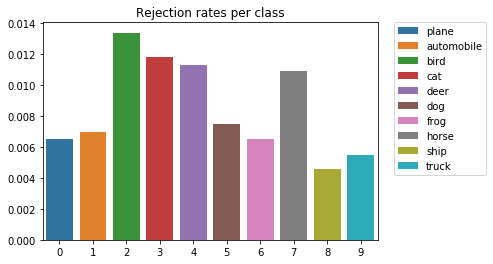

In [7]:
mis_ratio = rejected_classes/10000

classes = ('plane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
seaborn.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=mis_ratio, hue=classes, dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Rejection rates per class")
plt.show()